# Improving What's Cooking Using GNNs to redefine Culinary Boundaries


## Configuration de l'Environnement


In [1]:
import torch
from torch import Tensor
import numpy as np
import pandas as pd

print(f"Version de PyTorch: {torch.__version__}")

Version de PyTorch: 2.2.2+cpu


### Installation de PyTorch Geometric


In [2]:
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/nightly/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/nightly/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/pyg-team/pytorch_geometri

### Import des bibliothèques

In [3]:
from torch_geometric.data import download_url, extract_zip
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt

---
## Chargement et Exploration des Donnée

Le **FlavorGraph** est un graphe de connaissances culinaires qui contient :
- Des **nœuds** : ingrédients, recettes, composés chimiques
- Des **arêtes** : relations entre ces éléments avec un score de compatibilité

Pour ce projet, on se concentre uniquement sur les relations **ingrédient-ingrédient**.

### Chargement des arêtes (edges)

Chaque arête représente une relation entre deux éléments avec :
- `id_1`, `id_2` : identifiants des nœuds connectés
- `edge_type` : type de relation
- `score` : force de la relation (0-1)

In [4]:
edge_url = "https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/edges_191120.csv"
edges_df = pd.read_csv(edge_url)

print("Distribution des types d'arêtes:")
print(edges_df.edge_type.value_counts())
print(f"\nNombre total d'arêtes: {len(edges_df)}")

edges_df.head()

Distribution des types d'arêtes:
edge_type
ingr-ingr     111355
ingr-fcomp     35440
ingr-dcomp       384
Name: count, dtype: int64

Nombre total d'arêtes: 147179


,id_1,id_2,score,edge_type
0,5063,6083,0.337742,ingr-ingr
1,244,4620,0.093855,ingr-ingr
2,2253,6753,0.107870,ingr-ingr
3,2813,6228,0.092569,ingr-ingr
4,3016,6314,0.123897,ingr-ingr


### Filtrage : uniquement les relations ingrédient-ingrédient

On ne garde que les 111,355 premières lignes qui correspondent aux relations ingrédient-ingrédient (`entity_entity`). Cela simplifie le problème et se concentre sur les paires d'ingrédients.

In [5]:
# Filtrer uniquement les relations entity_entity (ingrédient-ingrédient)
edges_df = edges_df.iloc[:111355, :]

print("Après filtrage:")
print(edges_df.edge_type.value_counts())
print(f"\nAperçu des données:")
edges_df.head()

Après filtrage:
edge_type
ingr-ingr    111355
Name: count, dtype: int64

Aperçu des données:


,id_1,id_2,score,edge_type
0,5063,6083,0.337742,ingr-ingr
1,244,4620,0.093855,ingr-ingr
2,2253,6753,0.107870,ingr-ingr
3,2813,6228,0.092569,ingr-ingr
4,3016,6314,0.123897,ingr-ingr


### Chargement des nœuds (nodes)

Chaque nœud contient :
- `node_id` : identifiant unique
- `name` : nom de l'ingrédient/recette/composé
- `node_type` : type du nœud

In [6]:
node_url = "https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/nodes_191120.csv"
nodes_df = pd.read_csv(node_url)

print(f"Forme du DataFrame: {nodes_df.shape}")
print("\nAperçu des nœuds:")
nodes_df.head()

Forme du DataFrame: (8298, 5)

Aperçu des nœuds:


,node_id,name,id,node_type,is_hub
0,0,1%_fat_buttermilk,NaN,ingredient,no_hub
1,1,1%_fat_cottage_cheese,NaN,ingredient,no_hub
2,3,10%_cream,NaN,ingredient,no_hub
3,4,100%_bran,NaN,ingredient,no_hub
4,5,10_inch_flour_tortilla,NaN,ingredient,no_hub


### Analyse des types de nœuds

In [7]:
print("Distribution des types de nœuds:")
nodes_df.node_type.value_counts()

Distribution des types de nœuds:


node_type
ingredient    6653
compound      1645
Name: count, dtype: int64

### Filtrage des nœuds pertinents

On ne garde que les nœuds (ingrédients) qui apparaissent dans nos arêtes filtrées.

In [8]:
# Récupérer tous les IDs uniques présents dans les arêtes
relevant_node_ids = set(edges_df.id_1.values).union(set(edges_df.id_2.values))

# Filtrer le DataFrame des nœuds
nodes_df = nodes_df[nodes_df['node_id'].isin(relevant_node_ids)]

print(f"Nombre de nœuds après filtrage: {len(nodes_df)}")
print("\nTypes de nœuds restants:")
nodes_df.node_type.value_counts()

Nombre de nœuds après filtrage: 6653

Types de nœuds restants:


node_type
ingredient    6653
Name: count, dtype: int64

---
## Construction du Graphe

On construit maintenant un objet `Data` de PyTorch Geometric qui représente notre graphe.

### Étapes :
1. Créer un mapping des IDs de nœuds vers des indices contigus (0, 1, 2, ...)
2. Convertir les arêtes en format PyTorch (tenseurs)
3. Créer un graphe non-orienté (undirected)
4. Diviser en ensembles train/validation/test

In [9]:
# Initialisation du graphe
flavorGraph = Data()

# Extraction des poids des arêtes
edge_weight = torch.Tensor(edges_df.score.values)

# Extraction des indices de nœuds
node_index = torch.Tensor(nodes_df.node_id.values)

# Création d'un mapping : node_id -> index continu
node_map = dict()
for i in range(len(node_index)):
    node_map[int(node_index[i])] = i

print(f"Nombre de nœuds: {len(node_map)}")
print(f"Exemple de mapping: {list(node_map.items())[:5]}")

Nombre de nœuds: 6653
Exemple de mapping: [(0, 0), (1, 1), (3, 2), (4, 3), (5, 4)]


### Création de la matrice d'adjacence

Format PyG : `edge_index` est une matrice 2×N où chaque colonne est une arête [source, destination]

In [10]:
# Conversion des IDs d'arêtes vers les indices mappés
edge_index = torch.Tensor([
    edges_df.id_1.apply(lambda x: node_map[x]).values,
    edges_df.id_2.apply(lambda x: node_map[x]).values
])

# Construction du graphe
flavorGraph.x = node_index.view(node_index.size(0), -1)  # Features = node_id
flavorGraph.edge_index = edge_index.type(torch.int64)
flavorGraph.edge_weight = edge_weight

# Validation du graphe
flavorGraph.validate(raise_on_error=True)

# Conversion en graphe non-orienté
flavorGraph = ToUndirected()(flavorGraph)
print(f"Graphe non-orienté: {flavorGraph.is_undirected()}")
print(f"\nStatistiques du graphe:")
print(f"  - Nœuds: {flavorGraph.num_nodes}")
print(f"  - Arêtes: {flavorGraph.num_edges}")
print(f"  - Features par nœud: {flavorGraph.num_node_features}")

Graphe non-orienté: True

Statistiques du graphe:
  - Nœuds: 6653
  - Arêtes: 222710
  - Features par nœud: 1


/tmp/ipykernel_45552/3774677864.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.Tensor([


### Division Train/Validation/Test

**RandomLinkSplit** divise les arêtes du graphe en trois ensembles :
- **Train** : pour entraîner le modèle
- **Validation** : pour ajuster les hyperparamètres
- **Test** : pour évaluer les performances finales

Paramètres :
- `is_undirected=True` : graphe non-orienté
- `add_negative_train_samples=False` : on générera les samples négatifs nous-mêmes
- `disjoint_train_ratio=0.35` : 35% des arêtes pour validation/test

In [11]:
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    disjoint_train_ratio=0.35
)

train_data, val_data, test_data = transform(flavorGraph)

### Aperçu des données d'entraînement

In [12]:
print("Structure de train_data:")
print(train_data)
print("\nStructure de val_data:")
print(val_data)
print("\nStructure de test_data:")
print(test_data)

Structure de train_data:
Data(x=[6653, 1], edge_index=[2, 101334], edge_weight=[101334], edge_label=[27282], edge_label_index=[2, 27282])

Structure de val_data:
Data(x=[6653, 1], edge_index=[2, 155898], edge_weight=[155898], edge_label=[22270], edge_label_index=[2, 22270])

Structure de test_data:
Data(x=[6653, 1], edge_index=[2, 178168], edge_weight=[178168], edge_label=[44542], edge_label_index=[2, 44542])


---
## Modèle GCN (Graph Convolutional Network)

### Architecture du modèle

Le **GCN** fonctionne en deux étapes :

1. **Encodage** : Deux couches de convolution sur graphe qui agrègent les informations des voisins
   - Couche 1 : `num_features → 128 dimensions`
   - Couche 2 : `128 → 64 dimensions` (embeddings finaux)

2. **Décodage** : Prédit la probabilité d'existence d'une arête par produit scalaire des embeddings
   - Si `z[i] · z[j]` est élevé → l'arête (i,j) existe probablement

### Fonctions clés
- `encode()` : transforme le graphe en embeddings
- `decode()` : prédit des arêtes à partir des embeddings
- `decode_all()` : calcule toutes les probabilités d'arêtes possibles

In [13]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Deux couches de convolution sur graphe
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        """Encode le graphe en embeddings de dimension out_channels"""
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        """Prédit la probabilité d'arêtes spécifiques via produit scalaire"""
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        """Calcule la matrice complète de probabilités d'arêtes"""
        prob_adj = z @ z.t()  # Produit matriciel : NxD × DxN = NxN
        prob_adj = torch.sigmoid(prob_adj)  # Conversion en probabilités [0,1]
        return prob_adj

model = Net(flavorGraph.num_features, 128, 64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

### Fonctions d'entraînement et d'évaluation

**Entraînement** :
1. Encode le graphe
2. Génère des arêtes négatives (échantillonnage aléatoire)
3. Calcule la loss sur arêtes positives + négatives
4. Backpropagation et mise à jour des poids

**Évaluation** :
- Métrique : **ROC-AUC** (Area Under ROC Curve)
- Mesure la capacité à distinguer arêtes existantes vs. inexistantes

In [14]:
def train():
    model.train()
    optimizer.zero_grad()
    
    # Encodage du graphe
    z = model.encode(train_data.x, train_data.edge_index)

    # Échantillonnage négatif : génère des arêtes qui n'existent pas
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1),
        method='sparse'
    )

    # Concaténation arêtes positives + négatives
    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    # Prédiction et calcul de la loss
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    """Évalue le modèle avec la métrique ROC-AUC"""
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    
    # Calcul ROC-AUC
    y = data.edge_label.cpu().numpy()
    pred = out.cpu().numpy()
    return roc_auc_score(y, pred)

### Entraînement du modèle GCN

On entraîne pendant **150 epochs** et on sauvegarde :
- Les métriques de validation et test à chaque epoch
- Le meilleur modèle basé sur la validation
- Les probabilités finales pour toutes les paires d'ingrédients

In [15]:
validationMetrics_GCN = []
best_val_auc = 0
final_test_auc = 0

for epoch in range(0, 150):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    
    # Sauvegarde du meilleur modèle
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GCN.append([val_auc, test_auc])
    
    # Affichage tous les 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Meilleur Test AUC: {final_test_auc:.4f}')

# Calcul des probabilités finales
z = model.encode(test_data.x, test_data.edge_index)
final_edge_probs_GCN = model.decode_all(z)

Epoch: 000, Loss: 4327602.0000, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 209822.7344, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 209822.7344, Val: 0.5000, Test: 0.5000
Epoch: 020, Loss: 46967.1719, Val: 0.5000, Test: 0.5000
Epoch: 020, Loss: 46967.1719, Val: 0.5000, Test: 0.5000
Epoch: 030, Loss: 18131.0234, Val: 0.5000, Test: 0.5000
Epoch: 030, Loss: 18131.0234, Val: 0.5000, Test: 0.5000
Epoch: 040, Loss: 5104.5083, Val: 0.5000, Test: 0.5001
Epoch: 040, Loss: 5104.5083, Val: 0.5000, Test: 0.5001
Epoch: 050, Loss: 1945.0192, Val: 0.5002, Test: 0.5002
Epoch: 050, Loss: 1945.0192, Val: 0.5002, Test: 0.5002
Epoch: 060, Loss: 660.0077, Val: 0.5005, Test: 0.5004
Epoch: 060, Loss: 660.0077, Val: 0.5005, Test: 0.5004
Epoch: 070, Loss: 248.5652, Val: 0.5007, Test: 0.5006
Epoch: 070, Loss: 248.5652, Val: 0.5007, Test: 0.5006
Epoch: 080, Loss: 82.9554, Val: 0.5013, Test: 0.5008
Epoch: 080, Loss: 82.9554, Val: 0.5013, Test: 0.5008
Epoch: 090, Loss: 29.0217, Val: 0.5145, Test: 0.5161
Epoch: 09

### Visualisation des performances GCN

Courbe d'évolution du **Test AUC** au fil des epochs.

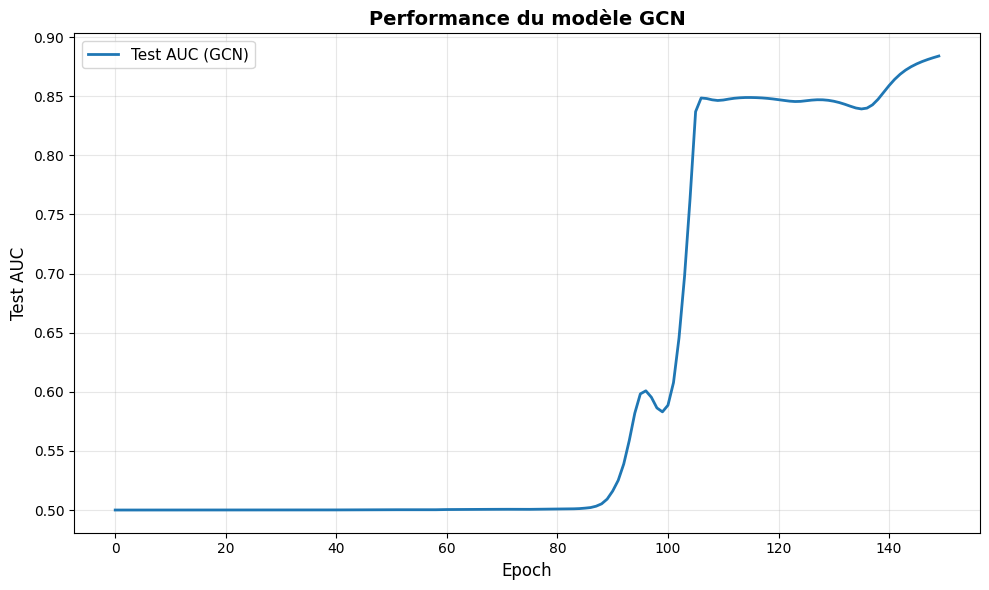

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_GCN)), 
         np.array(validationMetrics_GCN)[:, 1], 
         label='Test AUC (GCN)', 
         linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GCN', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GCN)

On part d'un ingrédient aléatoire et on suit les liens les plus probables pour créer une "recette" de 2-6 ingrédients.

In [17]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GCN:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    # Top 10 ingrédients les plus compatibles
    top_nodes = nodes_df.iloc[final_edge_probs_GCN.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

Recette générée avec GCN:
Ingrédient de départ: hard_alcoholic_cider

  1. sugar
  2. milk
  3. butter


---
## Modèle GraphSAGE

### Différences avec GCN

**GraphSAGE** (SAmple and aggreGatE) diffère du GCN par :
1. **Échantillonnage** : ne considère qu'un sous-ensemble de voisins (scalabilité)
2. **Agrégation** : plus flexible (mean, max, LSTM, etc.)

Dans PyG, `SAGEConv` utilise l'agrégation par moyenne.

In [18]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Remplacement des couches GCN par SAGEConv
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj

### Initialisation du modèle GraphSAGE

Même architecture que GCN : 1 → 128 → 64

In [19]:
model = Net(flavorGraph.num_features, 128, 64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

### Entraînement du modèle GraphSAGE

Même procédure que pour GCN : 150 epochs avec suivi des métriques.

In [20]:
validationMetrics_SAGE = []
best_val_auc = final_test_auc = 0


for epoch in range(0, 150):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_SAGE.append([val_auc, test_auc])
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Meilleur Test AUC: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_probs_SAGE = model.decode_all(z)

Epoch: 000, Loss: 54522800.0000, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 19023384.0000, Val: 0.5024, Test: 0.5012
Epoch: 010, Loss: 19023384.0000, Val: 0.5024, Test: 0.5012
Epoch: 020, Loss: 3167061.2500, Val: 0.5050, Test: 0.5025
Epoch: 020, Loss: 3167061.2500, Val: 0.5050, Test: 0.5025
Epoch: 030, Loss: 1453792.0000, Val: 0.5171, Test: 0.5123
Epoch: 030, Loss: 1453792.0000, Val: 0.5171, Test: 0.5123
Epoch: 040, Loss: 553252.7500, Val: 0.5197, Test: 0.5144
Epoch: 040, Loss: 553252.7500, Val: 0.5197, Test: 0.5144
Epoch: 050, Loss: 292122.1875, Val: 0.5282, Test: 0.5177
Epoch: 050, Loss: 292122.1875, Val: 0.5282, Test: 0.5177
Epoch: 060, Loss: 144289.5625, Val: 0.5300, Test: 0.5182
Epoch: 060, Loss: 144289.5625, Val: 0.5300, Test: 0.5182
Epoch: 070, Loss: 94674.6719, Val: 0.5419, Test: 0.5303
Epoch: 070, Loss: 94674.6719, Val: 0.5419, Test: 0.5303
Epoch: 080, Loss: 64567.5547, Val: 0.5393, Test: 0.5283
Epoch: 080, Loss: 64567.5547, Val: 0.5393, Test: 0.5283
Epoch: 090, Loss: 46923.2

### Visualisation des performances GraphSAGE

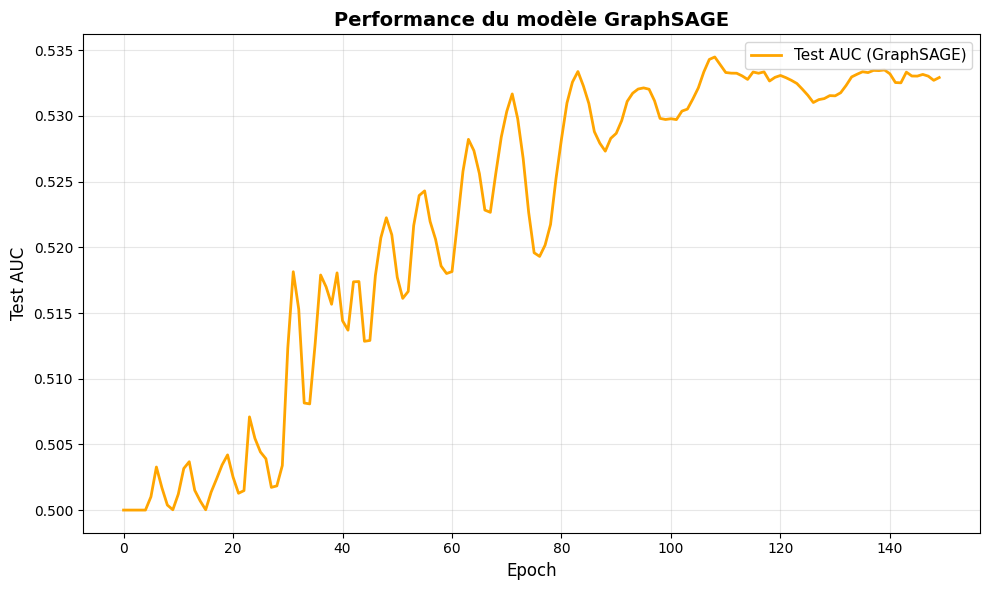

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_SAGE)), 
         np.array(validationMetrics_SAGE)[:, 1], 
         label='Test AUC (GraphSAGE)', 
         linewidth=2,
         color='orange')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GraphSAGE', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GraphSAGE)

In [22]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GraphSAGE:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    top_nodes = nodes_df.iloc[final_edge_probs_SAGE.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

Recette générée avec GraphSAGE:
Ingrédient de départ: pasta_dough

  1. 12_inch_pizza_crust
  2. 2%_buttermilk
  3. 1%_fat_buttermilk
  4. 100%_bran


---
## Comparaison des Modèles

Comparons visuellement les performances de **GCN** et **GraphSAGE** sur l'ensemble de test.

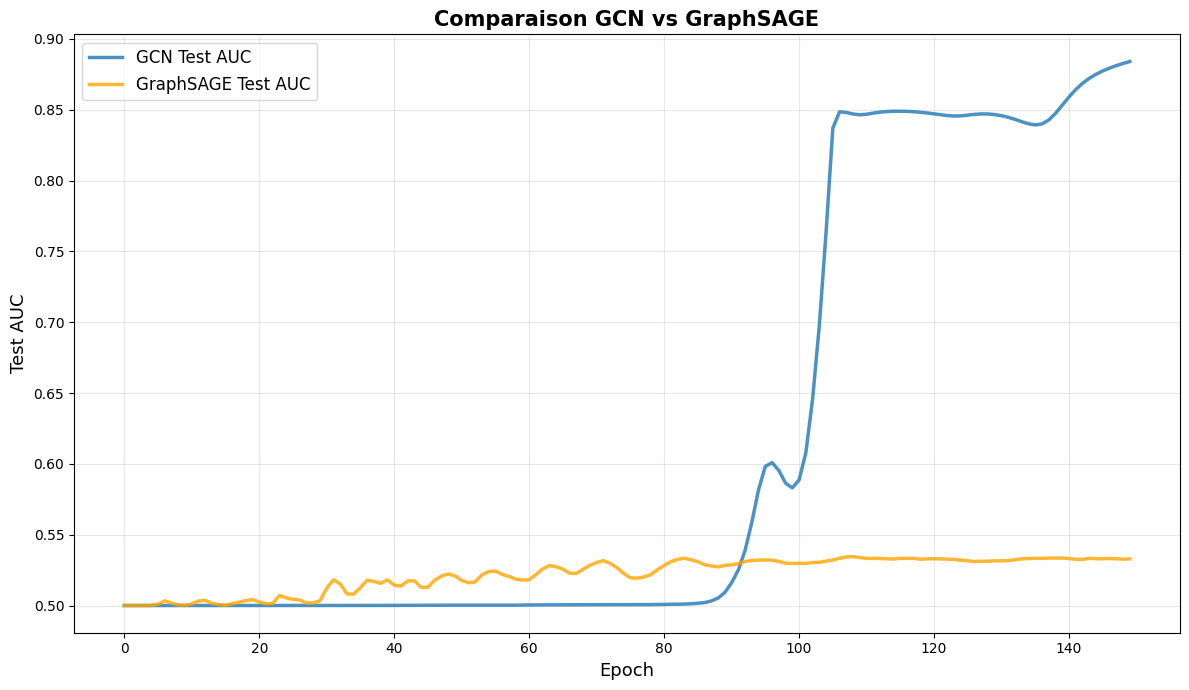


Résultats Finaux:
  GCN Test AUC:        0.8840
  GraphSAGE Test AUC:  0.5329
  Différence:          0.3511

GCN performe mieux de 65.88%


In [23]:
plt.figure(figsize=(12, 7))

plt.plot(np.arange(len(validationMetrics_GCN)), 
         np.array(validationMetrics_GCN)[:, 1], 
         label='GCN Test AUC', 
         linewidth=2.5,
         alpha=0.8)

plt.plot(np.arange(len(validationMetrics_SAGE)), 
         np.array(validationMetrics_SAGE)[:, 1], 
         label='GraphSAGE Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='orange')

plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Test AUC', fontsize=13)
plt.title('Comparaison GCN vs GraphSAGE', fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques finales
gcn_final = np.array(validationMetrics_GCN)[-1, 1]
sage_final = np.array(validationMetrics_SAGE)[-1, 1]

print("\nRésultats Finaux:")
print(f"  GCN Test AUC:        {gcn_final:.4f}")
print(f"  GraphSAGE Test AUC:  {sage_final:.4f}")
print(f"  Différence:          {abs(gcn_final - sage_final):.4f}")

if gcn_final > sage_final:
    print(f"\nGCN performe mieux de {((gcn_final - sage_final) / sage_final * 100):.2f}%")
else:
    print(f"\nGraphSAGE performe mieux de {((sage_final - gcn_final) / gcn_final * 100):.2f}%")

---
## Modèle GAT (Graph Attention Network)

### Mécanisme d'attention

**GAT** introduit un mécanisme d'**attention** qui permet au modèle d'apprendre l'importance de chaque voisin :
1. **Poids d'attention** : calcule un score pour chaque voisin
2. **Agrégation pondérée** : combine les informations en fonction de ces scores
3. **Multi-head attention** : utilise plusieurs mécanismes d'attention en parallèle pour capturer différents patterns

Avantages par rapport à GCN :
- Adaptabilité : pondération dynamique des voisins
- Interprétabilité : les poids d'attention révèlent les relations importantes
- Performance : souvent meilleure sur des graphes complexes

In [24]:
# Normalisation des features pour GAT et GIN
train_data_norm = train_data.clone()
val_data_norm = val_data.clone()
test_data_norm = test_data.clone()

mean = train_data.x.mean(dim=0, keepdim=True)
std = train_data.x.std(dim=0, keepdim=True)

train_data_norm.x = (train_data.x - mean) / (std + 1e-10)
val_data_norm.x = (val_data.x - mean) / (std + 1e-10)
test_data_norm.x = (test_data.x - mean) / (std + 1e-10)

print(f'Features normalisées: mean={train_data_norm.x.mean():.4f}, std={train_data_norm.x.std():.4f}')

Features normalisées: mean=-0.0000, std=1.0000


In [25]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        # Couches GAT avec Batch Normalization
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=dropout)
        self.bn1 = torch.nn.BatchNorm1d(heads * hidden_channels)
        
        self.conv2 = GATConv(heads * hidden_channels, out_channels, heads=1, concat=False, dropout=dropout)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj

### Initialisation du modèle GAT

Même architecture de base : 1 → 128 → 64, mais avec mécanisme d'attention multi-têtes.

In [26]:
model = Net(flavorGraph.num_features, 128, 64, heads=4, dropout=0.3)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

### Entraînement du modèle GAT

150 epochs avec mécanisme d'attention pour apprendre les pondérations optimales.

In [27]:
def train_gat():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data_norm.x, train_data_norm.edge_index)
    neg_edge_index = negative_sampling(edge_index=train_data_norm.edge_index, num_nodes=train_data_norm.num_nodes,
                                       num_neg_samples=train_data_norm.edge_label_index.size(1), method='sparse')
    edge_label_index = torch.cat([train_data_norm.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data_norm.edge_label, train_data_norm.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss

validationMetrics_GAT = []
best_val_auc = final_test_auc = 0

for epoch in range(0, 150):
    loss = train_gat()
    val_auc = test(val_data_norm)
    test_auc = test(test_data_norm)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GAT.append([val_auc, test_auc])
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Meilleur Test AUC: {final_test_auc:.4f}')

z = model.encode(test_data_norm.x, test_data_norm.edge_index)
final_edge_probs_GAT = model.decode_all(z)

Epoch: 000, Loss: 2.0790, Val: 0.3398, Test: 0.3396
Epoch: 010, Loss: 0.9060, Val: 0.3600, Test: 0.3626
Epoch: 010, Loss: 0.9060, Val: 0.3600, Test: 0.3626
Epoch: 020, Loss: 0.9803, Val: 0.3649, Test: 0.3679
Epoch: 020, Loss: 0.9803, Val: 0.3649, Test: 0.3679
Epoch: 030, Loss: 0.9131, Val: 0.3957, Test: 0.4029
Epoch: 030, Loss: 0.9131, Val: 0.3957, Test: 0.4029
Epoch: 040, Loss: 0.9314, Val: 0.4275, Test: 0.4356
Epoch: 040, Loss: 0.9314, Val: 0.4275, Test: 0.4356
Epoch: 050, Loss: 0.8059, Val: 0.4971, Test: 0.5019
Epoch: 050, Loss: 0.8059, Val: 0.4971, Test: 0.5019
Epoch: 060, Loss: 0.7870, Val: 0.5891, Test: 0.5933
Epoch: 060, Loss: 0.7870, Val: 0.5891, Test: 0.5933
Epoch: 070, Loss: 0.7783, Val: 0.5622, Test: 0.5592
Epoch: 070, Loss: 0.7783, Val: 0.5622, Test: 0.5592
Epoch: 080, Loss: 0.8640, Val: 0.5257, Test: 0.5211
Epoch: 080, Loss: 0.8640, Val: 0.5257, Test: 0.5211
Epoch: 090, Loss: 0.8398, Val: 0.4956, Test: 0.4945
Epoch: 090, Loss: 0.8398, Val: 0.4956, Test: 0.4945
Epoch: 100, 

### Visualisation des performances GAT

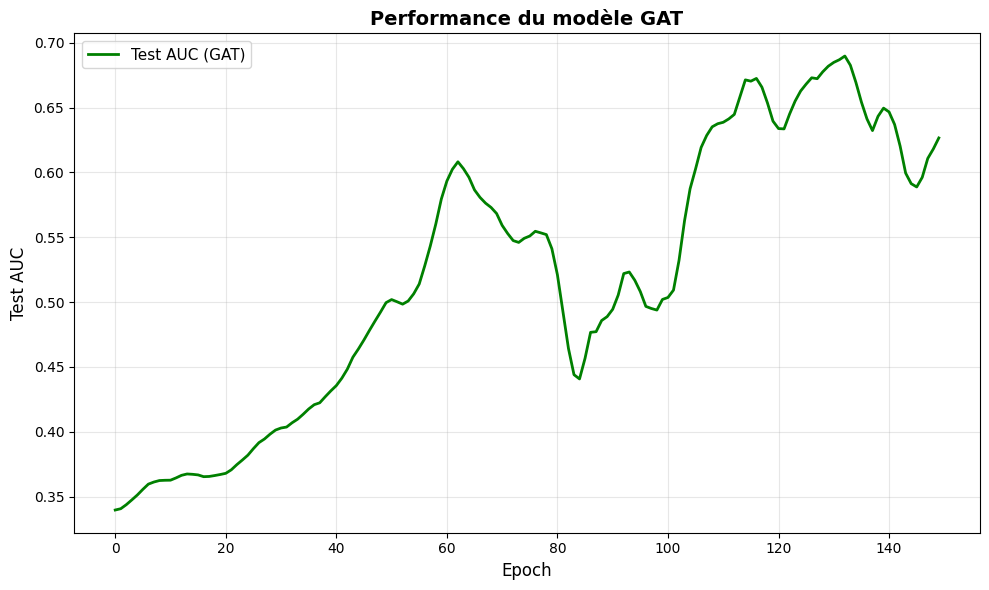

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_GAT)), 
         np.array(validationMetrics_GAT)[:, 1], 
         label='Test AUC (GAT)', 
         linewidth=2,
         color='green')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GAT', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GAT)

In [29]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GAT:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    top_nodes = nodes_df.iloc[final_edge_probs_GAT.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

Recette générée avec GAT:
Ingrédient de départ: parmesan_cheese

  1. alfalfa
  2. berry_juice
  3. abalone


---
## Modèle GIN (Graph Isomorphism Network)

### Mécanisme du GIN

**GIN** est basé sur le théorème du Weisfeiler-Lehman (WL) et maximise le pouvoir expressif des GNN :
1. **Agrégation injective** : utilise une fonction qui préserve l'information complète des voisins
2. **MLP** : applique un perceptron multicouche pour transformer les embeddings
3. **Expressivité** : capable de distinguer plus de structures de graphes que GCN ou GraphSAGE

Formule : `h^(k) = MLP^(k)((1 + ε^(k)) · h^(k-1) + SUM(h_j^(k-1)))` où ε est appris.

Avantages :
- Pouvoir discriminatif maximal parmi les GNN par passage de messages
- Capture les motifs structurels complexes
- Théoriquement aussi puissant que le test WL

In [30]:
from torch_geometric.nn import GINConv
from torch.nn import Sequential, Linear, ReLU
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        
        # MLP avec Batch Normalization pour la première couche
        nn1 = Sequential(
            Linear(in_channels, hidden_channels),
            torch.nn.BatchNorm1d(hidden_channels),
            ReLU(),
            torch.nn.Dropout(dropout),
            Linear(hidden_channels, hidden_channels),
            torch.nn.BatchNorm1d(hidden_channels)
        )
        self.conv1 = GINConv(nn1, train_eps=False)
        
        # MLP avec Batch Normalization pour la seconde couche
        nn2 = Sequential(
            Linear(hidden_channels, out_channels),
            torch.nn.BatchNorm1d(out_channels),
            ReLU(),
            torch.nn.Dropout(dropout),
            Linear(out_channels, out_channels),
            torch.nn.BatchNorm1d(out_channels)
        )
        self.conv2 = GINConv(nn2, train_eps=False)
        
        # Initialisation Xavier
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj

### Initialisation du modèle GIN

Architecture : 1 → 128 → 64 avec MLPs intégrés dans les couches GIN.

In [31]:
model = Net(flavorGraph.num_features, 128, 64, dropout=0.3)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)
criterion = torch.nn.BCEWithLogitsLoss()

### Entraînement du modèle GIN

150 epochs avec agrégation injective pour maximiser l'expressivité.

In [32]:
def train_gin():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data_norm.x, train_data_norm.edge_index)
    neg_edge_index = negative_sampling(edge_index=train_data_norm.edge_index, num_nodes=train_data_norm.num_nodes,
                                       num_neg_samples=train_data_norm.edge_label_index.size(1), method='sparse')
    edge_label_index = torch.cat([train_data_norm.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data_norm.edge_label, train_data_norm.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss

validationMetrics_GIN = []
best_val_auc = final_test_auc = 0

for epoch in range(0, 150):
    loss = train_gin()
    val_auc = test(val_data_norm)
    test_auc = test(test_data_norm)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GIN.append([val_auc, test_auc])
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Meilleur Test AUC: {final_test_auc:.4f}')

z = model.encode(test_data_norm.x, test_data_norm.edge_index)
final_edge_probs_GIN = model.decode_all(z)

Epoch: 000, Loss: 7.3559, Val: 0.5550, Test: 0.5312
Epoch: 010, Loss: 5.5428, Val: 0.7165, Test: 0.6704
Epoch: 010, Loss: 5.5428, Val: 0.7165, Test: 0.6704
Epoch: 020, Loss: 4.8926, Val: 0.6913, Test: 0.6531
Epoch: 020, Loss: 4.8926, Val: 0.6913, Test: 0.6531
Epoch: 030, Loss: 4.2509, Val: 0.6645, Test: 0.6327
Epoch: 030, Loss: 4.2509, Val: 0.6645, Test: 0.6327
Epoch: 040, Loss: 3.7091, Val: 0.6589, Test: 0.6305
Epoch: 040, Loss: 3.7091, Val: 0.6589, Test: 0.6305
Epoch: 050, Loss: 3.0693, Val: 0.6495, Test: 0.6223
Epoch: 050, Loss: 3.0693, Val: 0.6495, Test: 0.6223
Epoch: 060, Loss: 2.6794, Val: 0.6504, Test: 0.6229
Epoch: 060, Loss: 2.6794, Val: 0.6504, Test: 0.6229
Epoch: 070, Loss: 2.3866, Val: 0.6389, Test: 0.6222
Epoch: 070, Loss: 2.3866, Val: 0.6389, Test: 0.6222
Epoch: 080, Loss: 2.1085, Val: 0.6314, Test: 0.6181
Epoch: 080, Loss: 2.1085, Val: 0.6314, Test: 0.6181
Epoch: 090, Loss: 1.9636, Val: 0.5887, Test: 0.5936
Epoch: 090, Loss: 1.9636, Val: 0.5887, Test: 0.5936
Epoch: 100, 

### Visualisation des performances GIN

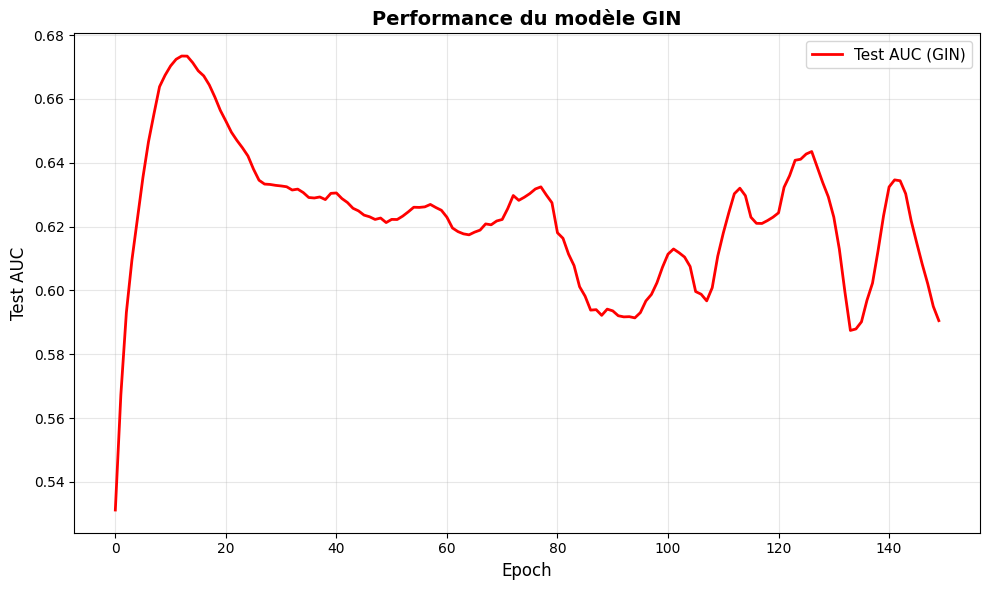

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_GIN)), 
         np.array(validationMetrics_GIN)[:, 1], 
         label='Test AUC (GIN)', 
         linewidth=2,
         color='red')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GIN', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GIN)

In [34]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GIN:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    top_nodes = nodes_df.iloc[final_edge_probs_GIN.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

Recette générée avec GIN:
Ingrédient de départ: orange,_juice_of

  1. 10_inch_flour_tortilla
  2. 1%_fat_cottage_cheese
  3. 80%_lean_ground_beef


---
## Comparaison Complète des 4 Modèles

Comparons maintenant les performances de **GCN**, **GraphSAGE**, **GAT** et **GIN** sur l'ensemble de test.

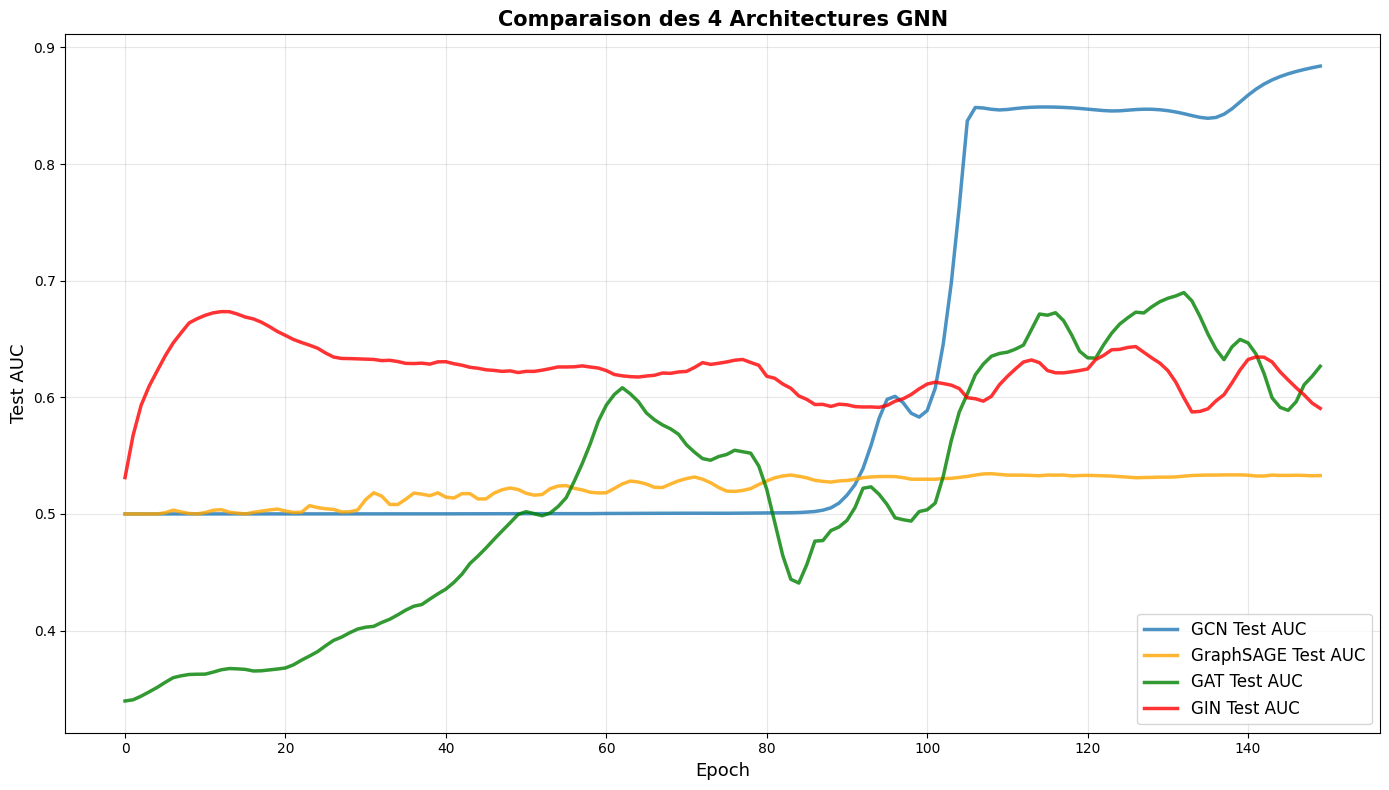


RÉSULTATS FINAUX - Comparaison des Modèles
  GCN Test AUC:        0.8840
  GraphSAGE Test AUC:  0.5329
  GAT Test AUC:        0.6266
  GIN Test AUC:        0.5905


In [36]:
plt.figure(figsize=(14, 8))

plt.plot(np.arange(len(validationMetrics_GCN)), 
         np.array(validationMetrics_GCN)[:, 1], 
         label='GCN Test AUC', 
         linewidth=2.5,
         alpha=0.8)

plt.plot(np.arange(len(validationMetrics_SAGE)), 
         np.array(validationMetrics_SAGE)[:, 1], 
         label='GraphSAGE Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='orange')

plt.plot(np.arange(len(validationMetrics_GAT)), 
         np.array(validationMetrics_GAT)[:, 1], 
         label='GAT Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='green')

plt.plot(np.arange(len(validationMetrics_GIN)), 
         np.array(validationMetrics_GIN)[:, 1], 
         label='GIN Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='red')

plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Test AUC', fontsize=13)
plt.title('Comparaison des 4 Architectures GNN', fontsize=15, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques finales
gcn_final = np.array(validationMetrics_GCN)[-1, 1]
sage_final = np.array(validationMetrics_SAGE)[-1, 1]
gat_final = np.array(validationMetrics_GAT)[-1, 1]
gin_final = np.array(validationMetrics_GIN)[-1, 1]

print("\n" + "="*60)
print("RÉSULTATS FINAUX - Comparaison des Modèles")
print("="*60)
print(f"  GCN Test AUC:        {gcn_final:.4f}")
print(f"  GraphSAGE Test AUC:  {sage_final:.4f}")
print(f"  GAT Test AUC:        {gat_final:.4f}")
print(f"  GIN Test AUC:        {gin_final:.4f}")
print("="*60)

# Déterminer le meilleur modèle
results = {
    'GCN': gcn_final,
    'GraphSAGE': sage_final,
    'GAT': gat_final,
    'GIN': gin_final
}

best_model = max(results, key=results.get)
best_score = results[best_model]